# Dataloaders

In [ ]:
# hide
import sys
sys.path.append("..")
from nbdev.showdoc import *

In [ ]:
# export
# default_exp data

import SimpleITK as sitk
import re
import pathlib
import torchvision

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [ ]:
# export
from faimed3d.basics import *
from faimed3d.preprocess import *
from faimed3d.augment import *


## Get data paths and labels

Data is divided into a train, valid and test dataset of different patients, which either have prostate cancer or are healthy. 
Each patient has three MRI sequences: T2, T1map and ADC. These sequences differ regarding the number of slices and resolution. 

At first, the paths to the data are specified: 

In [ ]:
d = pd.read_csv('../data/radiopaedia_cases.csv')

Raw pixel data for DICOM must sometimes undergo affine transformation (e.g. to be converted to Houndsfiel Units). `PreProcessDicom` is a convenience function which can perform a few frequently needed manipulations with the pixel data. 

In [ ]:
# export
class PreprocessDicom(DisplayedTransform):
    "Transforms a TensorDicom3D volume to float and normalizes the data"
    def __init__(self, rescale=True,
                 correct_spacing=True, spacing = 1,
                 clip_high_values=False, clipping_range=(-2000, 10000)):
        """
        Args:
            rescale (bool): if pixel values should be scaled according to the rescale intercept and slope
            correct_spacing (bool): if spacing of all volumes should be set to a unified value.
            spacing (int): new pixel spacing, default is 1.
            clip_high_values (bool): if abriatry high values shoule be clipped
            clipping_rang (tuple or list): min and maximum to clip values. important when dealing with beam hardening artifacts.
        """

        store_attr()
    def encodes(self, x:(TensorDicom3D, TensorMask3D)):
        if isinstance(x, TensorMask3D): return x
        if hasattr(x, 'metadata'): # numpy arrays will not have metadata
            if self.rescale: x = x.rescale_pixeldata()
            if self.correct_spacing: x = x.size_correction(self.spacing)
        if self.clip_high_values: x = x.clamp(self.clipping_range[0],
                                              self.clipping_range[1])
        return x.float()

In [ ]:
# export 
@patch
def scale_to(t:TensorDicom3D, mean, std):
    mask = t.ne(0) # ne not compatible with __torch_function__ reimplementation
    mean_orig, std_orig = t[mask].mean(), t[mask].std()
    return mean + (t - mean_orig) * (std/std_orig)


class AddColorChannel(DisplayedTransform):
    "Transforms Tensor to Pseudo RGB and normalizes to Kinteics Stats"
    split_idx,order = None, 99
    def __init__(self, p=1.):
        store_attr()

    def encodes(self, x:TensorDicom3D):
        if x.ndim == 3: x = x.unsqueeze(0) # make bs=2 form bs=1 batches
        if x.ndim == 4:
            #x1 = torch.stack([item.scale_to(0.43216, 0.22803) for item in torch.unbind(x)])
            #x2 = torch.stack([item.scale_to(0.394666, 0.22145) for item in torch.unbind(x)])
            #x3 = torch.stack([item.scale_to(0.37645, 0.216989) for item in torch.unbind(x)])
            return torch.stack((x, x, x), 1)
        else: return x

    def encodes(self, x:TensorMask3D):
        if x.ndim == 3: x = x.unsqueeze(0) # make bs=2 form bs=1 batches
        if x.ndim == 4: x = x.unsqueeze(1)
        return x

When using multiple sequences per examination, those sequences can differ in size, pixel spacing, pixel resolution, field of view and even orientation. SimpleITK provides functions to resample multiple images to a reference image, so the different sequences match.  
Resampling assumes that the images are somewhat in the same plane and show the same region. Resampling axial and sagittal images will not yield good results. 

In [ ]:
# export
class SequenceResampling(object):
    '''
    resamples different sequences from one examination to the same spacing, orientation and direction and to
    a uniform size.
    IMPORTANT SimpleITK expects axis of the 3D volume to be specified as W x H x D while in PyTorch you would
    specify the axis as (B x C) x D x H x W. So if you want a Tensor of size (B x C) x 10 x 112 x 112 you'll
    have to pass `size` as 112 x 112 x 10.
    '''

    def __init__(self, size:(list, tuple), n_inp:int, resample_to_first=False):
        '''
        Args:
            size: Size of the resampled images
            n_inp: number of input images
            resample_to_fisrt: If true, the origin and direction of the first input image are used as reference
        '''

        if isinstance(size, tuple):size=list(size)
        assert len(size) == 3, 'size must be a list or tuple specifing the Width, Height and Depth of the reference image'
        store_attr()

    def __call__(self, batch:tuple):
        # batch is a list of tuples
        # len of the list == batch_size
        # tuple contains input images and target image/class. len of tuple is equal to n_inp + n_targets
        return [self.resample_items(items) for items in batch]

    def resample_items(self, items:tuple):
        xb = self.resample(items[0:self.n_inp])
        yb = self.resample(items[self.n_inp:])
        return (*xb, *yb)

    def resample(self, items:(list, tuple)):
        'converts Tensors back to SimpleITK.Image to allow processing'
        if isinstance(items[0], TensorDicom3D):
            resampling_method = sitk.sitkLinear
            cls = items[0].__class__
        elif isinstance(items[0], TensorMask3D):
            resampling_method = sitk.sitkNearestNeighbor
            cls = items[0].__class__
        else: return items
        # Reading images first and then converting them back seems counteintuitive but allows easy integration into the DataLoader
        items = [item.as_sitk() for item in items]
        items = self._resample(items, resampling_method)
        return [cls.create(item) for item in items]

    def _resample(self, data:list, resample_method:(sitk.sitkLinear, sitk.sitkNearestNeighbor)):
        '''
        Creates a reference image the different sequences are resampled to as describet at:
            https://github.com/SimpleITK/ISBI2018_TUTORIAL/blob/master/python/03_data_augmentation.ipynb
        Args:
            data: list of sequences
            resample_method: Method for resampling the image. sitkLinear should be used for images, sitkNearestNeighbor for masks
        Returns:
            list of resampled sequences
        '''
        dimension = data[0].GetDimension()
        assert dimension == 3, 'You tried to pass an image that is not threedimensional'
        # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
        reference_physical_size = np.zeros(dimension)
        for img in data:
            reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(img.GetSize(), img.GetSpacing(), reference_physical_size)]
        # Create the reference image with a zero origin, identity direction cosine matrix and dimension
        if self.resample_to_first:
            reference_origin = data[0].GetOrigin()
            reference_direction = data[0].GetDirection()
        else:
            reference_origin = np.zeros(dimension)
            reference_direction = np.identity(dimension).flatten()
        reference_size = self.size
        reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

        reference_image = sitk.Image(reference_size, data[0].GetPixelIDValue())
        reference_image.SetOrigin(reference_origin)
        reference_image.SetSpacing(reference_spacing)
        reference_image.SetDirection(reference_direction)

        # Always use the TransformContinuousIndexToPhysicalPoint to compute an indexed point's physical coordinates as
        # this takes into account size, spacing and direction cosines. For the vast majority of images, the direction
        # cosines are the identity matrix, but when this isn't the case simply multiplying the central index by the
        # spacing will not yield the correct coordinates resulting in a long debugging session.
        reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

        for i, img in enumerate(data):
            # Transform which maps from the reference_image to the current img with the translation mapping the image
            # origins to each other.
            transform = sitk.AffineTransform(dimension)
            transform.SetMatrix(img.GetDirection())
            transform.SetTranslation(np.array(img.GetOrigin()) - reference_origin)
            # Modify the transformation to align the centers of the original and reference image instead of their origins.
            centering_transform = sitk.TranslationTransform(dimension)
            img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
            centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
            centered_transform = sitk.Transform(transform)
            # The tutorial in the link is with SimpleITK v1, faimed3d uses v2 where AddTransforms is removed and CompositeTransforms should be used
            centered_transform = sitk.CompositeTransform([centered_transform, centering_transform])
            # Using the linear interpolator as these are intensity images, if there is a need to resample a ground truth
            # segmentation then the segmentation image should be resampled using the NearestNeighbor interpolator so that
            # no new labels are introduced.
            img = sitk.Resample(img, reference_image, centered_transform, resample_method, 0.0)
            data[i] = img
        return tuple(data)

In [ ]:
# export
def ImageBlock3D(cls=TensorDicom3D, **kwargs):
    "A `TransformBlock` for images of `cls`. For possible kwargs see PreporcessDicom."
    return TransformBlock(type_tfms=cls.create, batch_tfms=[PreprocessDicom(**kwargs)])

def MaskBlock3D(cls=TensorMask3D, codes=None):
    "A `TransformBlock` for images of `cls`. For possible kwargs see PreporcessDicom."
    return TransformBlock(type_tfms=cls.create, item_tfms=AddMaskCodes(codes=codes))

## Dataloaders for image classification

In [ ]:
# export
class ImageDataLoaders3D(DataLoaders):
    "Nearly identical to fastai `ImageDataLoaders` but adapted for 3D data with some preprocessing steps added"

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, rescale_method=None, size_for_resampling=None,
                resample_to_first=False, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"

        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)

        if rescale_method is None: rescale_method = MaxScale()
        if item_tfms is not None:
            item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]
        else: item_tfms = rescale_method

        if batch_tfms is not None:
            batch_tfms = [*batch_tfms, AddColorChannel()] if isinstance(batch_tfms, list) else [batch_tfms, AddColorChannel()]
        else: batch_tfms = AddColorChannel()

        if not isinstance(fn_col, list): fn_col = [fn_col]
        if len(fn_col) > 1:
            if size_for_resampling is None:
                raise TypeError('Expected `size_for_resampling` to be a list or tuple but got None. '
                                'If you are using multiple inputs the inputs need to be resampled to a uniform size, spacing, '
                                'orientation and direction. For this you need to pass a `size_for_resampling` in format (width, height, depth). '
                                'Note, that you should not provide any resizing operations in the `item_tfms` as they may corrupt the '
                                'physical properties of the input images and will also be overwritten during resampling')
            Resampler = SequenceResampling(size_for_resampling, len(fn_col), resample_to_first)

        dblock = DataBlock(blocks=(*[ImageBlock3D(cls=TensorDicom3D) for i in fn_col], y_block),
                           get_x=[ColReader(col, pref=pref, suff=suff) for col in fn_col],
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms,
                           n_inp = len(fn_col))
        return cls.from_dblock(dblock, df, path=path,
                              before_batch = Resampler if len(fn_col) > 1 else None,
                               **kwargs)

    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `label_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None,
                    batch_tfms=None, rescale_method=None,**kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        
        if rescale_method is None: rescale_method = MaxScale()
        if item_tfms is not None:
            item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]
        else: item_tfms = rescale_method

        if batch_tfms is not None:
            batch_tfms = [*batch_tfms, AddColorChannel()] if isinstance(batch_tfms, list) else [batch_tfms, AddColorChannel()]
        else: batch_tfms = AddColorChannel()
        
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        get_items = get_volumetric_files if valid_pct else partial(get_volumetric_files, folders=[train, valid])
        dblock = DataBlock(blocks=(ImageBlock3D(cls=TensorDicom3D), CategoryBlock(vocab=vocab)),
                           get_items=get_items,
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`"
        raise NotImplementedError('Currently only from_df and from_csv are supported. '
                                  'You can raise a feature request on Github (https://github.com/kbressem/faimed3d/),'
                                  ' if you need this feature implemented. ')

    @classmethod
    def from_name_func(cls, path, fnames, label_func, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with `label_func`"
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, **kwargs):
        "Create from list of `fnames` in `path`s with re expression `pat`"
        return cls.from_path_func(path, fnames, RegexLabeller(pat), **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with re expression `pat`"
        return cls.from_name_func(path, fnames, RegexLabeller(pat), **kwargs)

In [ ]:
# export
supported_extensions = {'.dcm', '.nii.gz', '.nii', '.nrrd', '.avi', '.npy'}

def get_volumetric_files(path, recurse=True, folders=None):
    "Get medical volumetric files or video in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=supported_extensions, recurse=recurse, folders=folders)

In [ ]:
dls = ImageDataLoaders3D.from_df(d, 
                                 item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), 
                                                          resize_to = (20, 150, 150), 
                                                          perc_crop = True),
                                 bs = 2 
                                 )


In [ ]:
from fastai.data.core import DataLoaders # for compatibility with show_docs

In [ ]:
# export
@patch
def show_batch_3d(dls:DataLoaders, with_mask=False,
                  alpha_mask=0.3, figsize = (15, 15), **kwargs):
    "Workaround until implemented into dls as dls.show_batch_3d()"
    xb, yb = dls.one_batch()
    xb.show(figsize=figsize, **kwargs)
    if with_mask: yb.show(add_to_existing = True, alpha = alpha_mask,
                          cmap = 'jet', figsize=figsize, **kwargs)
    if isinstance(yb, TensorCategory):
        print(yb)

/home/bressekk/Documents/faimed3d/nbs/faimed3d/basics.py:264: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Removing the first dimension
  warn('Object is not a rank 3 tensor but a rank {} tensor. Removing the first dimension'.format(t.ndim))


TensorCategory([0, 2], device='cuda:0')


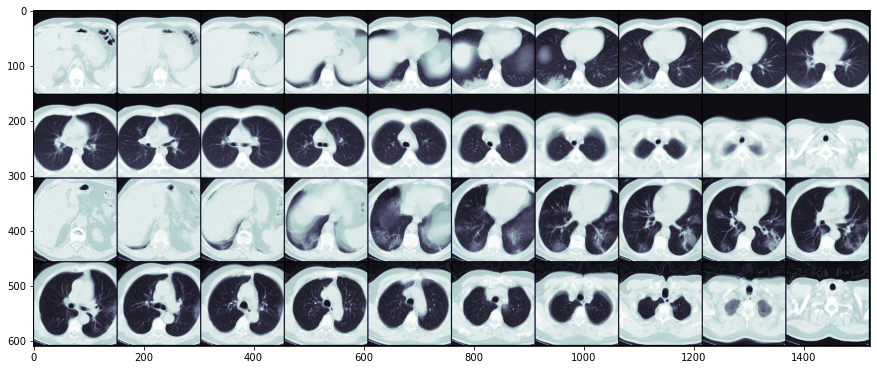

In [ ]:
dls.show_batch_3d(axis = 0, nrow = 10)

In [ ]:
from torch import Tensor # for show_docs

In [ ]:
# export
@patch
def to_numpy(x:Tensor): return x.detach().cpu().numpy()

@patch
def show_hist(dls:DataLoaders, bins=100, with_stats=False):
    xb, yb = dls.one_batch()

    if with_stats:
        b_min = xb.min().to_numpy()
        b_max = xb.max().to_numpy()
        mean = torch.mean(xb)
        diffs = xb - mean
        var = torch.mean(torch.pow(diffs, 2.0))
        std = torch.pow(var, 0.5)
        zscores = diffs / std
        skews = torch.mean(torch.pow(zscores, 3.0))
        kurt = torch.mean(torch.pow(zscores, 4.0)) - 3.0
        print('batch mean: {}, std: {}'.format(mean.to_numpy(), std.to_numpy()))
        print('px range: {} - {}'.format(b_min, b_max))
        print('skewness: {}, kurtosis:{}'.format(skews.to_numpy(), kurt.to_numpy()))

    plt.hist(xb.detach().cpu().flatten().numpy(), bins = bins)

batch mean: 0.6159189939498901, std: 0.3389136791229248
px range: 0.0 - 1.0
skewness: -0.54209303855896, kurtosis:-1.48134183883667


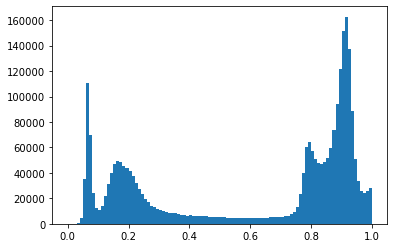

In [ ]:
dls.show_hist(with_stats=True)

## Dataloaders for segmentation

In [ ]:
#export
class SegmentationDataLoaders3D(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for segmentation problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)

    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, codes=None,
                valid_col=None, item_tfms=None, batch_tfms=None, rescale_method=None, size_for_resampling=None,resample_to_first=False, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"

        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)

        if rescale_method is None: rescale_method = MaxScale()
        if item_tfms is not None:
            item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]
        else: item_tfms = rescale_method

        if batch_tfms is not None:
            batch_tfms = [*batch_tfms, AddColorChannel()] if isinstance(batch_tfms, list) else [batch_tfms, AddColorChannel()]
        else: batch_tfms = AddColorChannel()

        if not isinstance(fn_col, list): fn_col = [fn_col]
        if not isinstance(label_col, list): label_col = [label_col]
        if len(fn_col) > 1:
            if size_for_resampling is None:
                raise TypeError('Expected `size_for_resampling` to be a list or tuple but got none. '
                                'If you are using multiple inputs the inputs need to be resampled to a uniform size, spacing, '
                                'orientation and direction. For this you need to pass a `size_for_resampling` in format (width, height, depth). '
                                'Note, that you should not provide any resizing operations in the `item_tfms` as they may corrupt the '
                                'physical properties of the input images and will also be overwritten during resampling')
            Resampler = SequenceResampling(size_for_resampling, len(fn_col), resample_to_first)

        dblock = DataBlock(blocks=(*[ImageBlock3D(cls=TensorDicom3D) for i in fn_col],
                                   *[MaskBlock3D(codes=codes) for i in label_col]),
                           get_x=[ColReader(col, pref=pref, suff=suff) for col in fn_col],
                           get_y=[ColReader(col, pref=pref, suff=suff) for col in label_col],
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms,
                           n_inp = len(fn_col))

        return cls.from_dblock(dblock, df, path=path,
                              before_batch = Resampler if len(fn_col) > 1 else None,
                               **kwargs)

    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `label_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)

In [ ]:
dls = SegmentationDataLoaders3D.from_df(d, 
                                        fn_col=[0,0],
                                        label_col = [1,1],
                                        size_for_resampling=(150,150,20),
                                 #item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (20, 150, 150), perc_crop = True), 
                                 batch_size = 2)
#dls.show_batch_3d(axis = 0, nrow = 10, with_mask = True)

In [ ]:
xb1, xb2, yb1, yb2 = dls.one_batch()

/home/bressekk/Documents/faimed3d/nbs/faimed3d/basics.py:264: UserWarning: Object is not a rank 3 tensor but a rank 4 tensor. Removing the first dimension
  warn('Object is not a rank 3 tensor but a rank {} tensor. Removing the first dimension'.format(t.ndim))


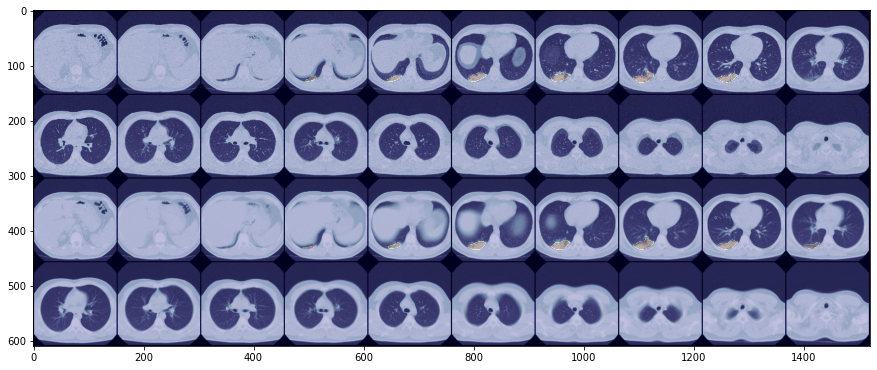

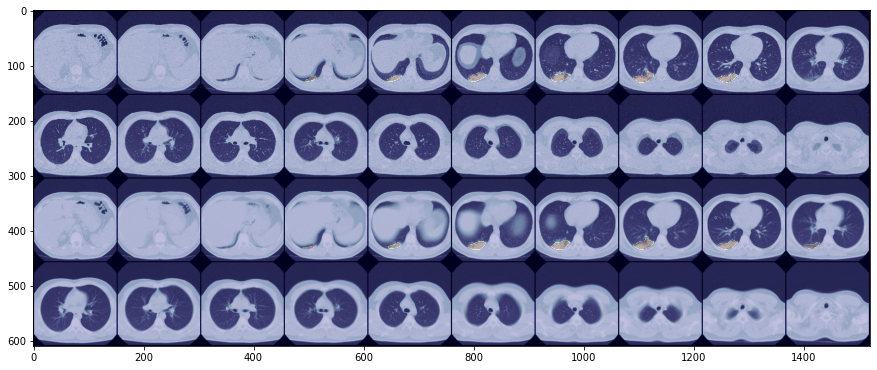

In [ ]:
xb1.show()
yb1.show(add_to_existing=True, alpha=0.25, cmap='jet')
xb2.show()
yb2.show(add_to_existing=True, alpha=0.25, cmap='jet')


When displaying the masks it may occure that Nifti images are rotated and do not fit the original DICOM. Most likely this is due to different frames of reference. 
In Simple-ITK, it is LPS, while NIfTI and FSL use RAS, so those matrices are the same after accounting for frame of reference (taken and adapted from https://discourse.itk.org/t/nifti-orientation-issues/431).
So, luckly the malrotations are systematic and can be scripted.

```python
    def convert(fn):

        if 'Gesund' in fn: return # healthy patients were already flipped once
        im = sitk.ReadImage(fn)
        arr = sitk.GetArrayFromImage(im)
        arr = np.rot90(arr, 0)
        arr = np.flip(arr, 1)
        im2 = sitk.GetImageFromArray(arr)

        for k in im.GetMetaDataKeys(): # Copy meta data from original image before overwriting it. 
            im2.SetMetaData(k, im.GetMetaData(k))

        sitk.WriteImage(im2, fn)
        return im2
    
    
    for s in segmentation_train: 
    convert(str(s))
````

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 01_basics.ipynb.
Converted 02_preprocessing.ipynb.
Converted 03_transforms.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05_layers.ipynb.
Converted 06_learner.ipynb.
Converted 06a_models.alexnet.ipynb.
Converted 06b_models.resnet.ipynb.
Converted 06c_model.efficientnet.ipynb.
Converted 06d_models.unet.ipynb.
Converted 06f_models.losses.ipynb.
Converted 07_callback.ipynb.
Converted index.ipynb.
